In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import random
import sys
import time

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import EvalTransform, InferenceTransform
from mask_generator.utils.dataset_utils import DatasetLoaderFactory

In [19]:
def load_image(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def load_mask(mask_path: str) -> np.ndarray:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = (mask >= 1).astype(np.uint8)
    return mask

In [20]:
# DATASET_DIR = "../Datasets/test/MoLane"
DATASET_DIR = "../Datasets/train/simu_v0"

pairs_path = DatasetLoaderFactory.get_loader(
        DATASET_DIR,
    ).get_pairs()

print(f"Successfully loaded {len(pairs_path)} pairs of images and masks.")

Successfully loaded 4817 pairs of images and masks.


In [28]:
image_path, mask_path = random.choice(pairs_path)
print(f"Selected pair: {image_path}, {mask_path}")

img_np = load_image(image_path)
mask_np = load_mask(mask_path)

eval_transform = EvalTransform(pad_divisor=32, to_tensor=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
infer_transform = InferenceTransform(pad_divisor=32, device=device)

eval_img, eval_mask = eval_transform(img_np, mask_np)

infer_img, infer_mask = infer_transform(img_np, mask_np)
print(f"Eval image shape: {eval_img.shape}, Eval mask shape: {eval_mask.shape}")
print(f"Infer image shape: {infer_img.shape}, Infer mask shape: {infer_mask.shape}")

Selected pair: ../Datasets/train/simu_v0\Images\image_dbd4f14a-0034-4b6b-8d06-85a869e746c6.png, ../Datasets/train/simu_v0\Masks\mask_dbd4f14a-0034-4b6b-8d06-85a869e746c6.png
Using device: cuda
Eval image shape: torch.Size([3, 256, 352]), Eval mask shape: torch.Size([1, 256, 352])
Infer image shape: torch.Size([3, 256, 352]), Infer mask shape: torch.Size([1, 256, 352])


In [22]:
def compare_tensors(t1: torch.Tensor, t2: torch.Tensor, name: str = "Tensor", atol=1e-4, rtol=1e-4):
    is_close = torch.allclose(t1, t2, atol=atol, rtol=rtol)
    max_diff = (t1 - t2).abs().max().item()
    print(f"{name}: {'✅ Identique' if is_close else '❌ Différent'}, max diff = {max_diff:.6f}")
    return is_close

infer_img = infer_img.cpu()
infer_mask = infer_mask.cpu()

print(f"Eval image dtype: {eval_img.dtype}, Infer image dtype: {infer_img.dtype}")
print(f"Eval mask dtype: {eval_mask.dtype}, Infer mask dtype: {infer_mask.dtype}")

compare_tensors(eval_img, infer_img, "Image")
compare_tensors(eval_mask, infer_mask, "Masque")

Eval image dtype: torch.float32, Infer image dtype: torch.float32
Eval mask dtype: torch.float32, Infer mask dtype: torch.float32
Image: ✅ Identique, max diff = 0.000001
Masque: ✅ Identique, max diff = 0.000000


True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


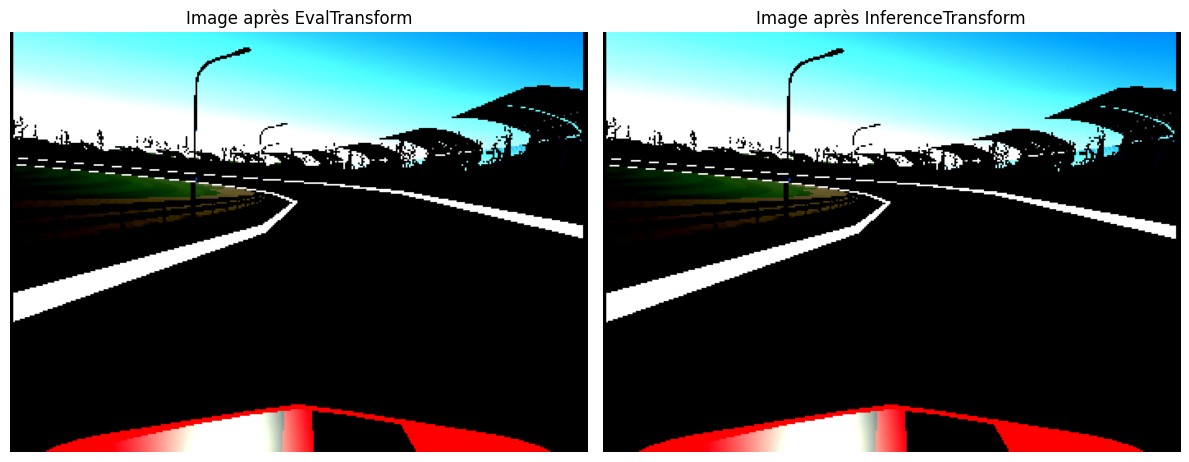

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(eval_img.permute(1, 2, 0).numpy())
plt.title("Image après EvalTransform")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(infer_img.permute(1, 2, 0).numpy())
plt.title("Image après InferenceTransform")
plt.axis("off")
plt.tight_layout()
plt.show()


In [24]:
def check_padding(tensor: torch.Tensor, pad_divisor: int, name: str):
    h, w = tensor.shape[-2:]
    is_valid = h % pad_divisor == 0 and w % pad_divisor == 0
    print(f"{name} padded correctly: {'✅' if is_valid else '❌'} (H={h}, W={w})")

check_padding(eval_img, 32, "Eval image")
check_padding(infer_img, 32, "Infer image")
check_padding(eval_mask, 32, "Eval mask")
check_padding(infer_mask, 32, "Infer mask")

Eval image padded correctly: ✅ (H=256, W=352)
Infer image padded correctly: ✅ (H=256, W=352)
Eval mask padded correctly: ✅ (H=256, W=352)
Infer mask padded correctly: ✅ (H=256, W=352)


In [53]:
NUM_SAMPLES = 1000

sampled_pairs = random.sample(list(pairs_path), NUM_SAMPLES)

def warmup_transform(transform_fn, device='cpu', num_iters=50):
    print(f"Warm-up on device {device}...")
    for _ in range(num_iters):
        image_path, mask_path = random.choice(sampled_pairs)
        img_np = load_image(image_path)
        mask_np = load_mask(mask_path)

        _ = transform_fn(img_np, mask_np)

    if device == 'cuda':
        torch.cuda.synchronize()

def benchmark_transform(transform_fn, label, device='cpu'):
    times = []
    for image_path, mask_path in sampled_pairs:
        img_np = load_image(image_path)
        mask_np = load_mask(mask_path)

        torch.cuda.synchronize() if device == 'cuda' else None
        start = time.time()

        _ = transform_fn(img_np, mask_np)

        torch.cuda.synchronize() if device == 'cuda' else None
        times.append(time.time() - start)

    avg_ms = np.mean(times) * 1000
    std_ms = np.std(times) * 1000
    print(f"{label} - Temps moyen: {avg_ms:.2f} ms (± {std_ms:.2f}) sur {NUM_SAMPLES} images.")

benchmark_transform(eval_transform, "Albumentations (EvalTransform)", device='cpu')
warmup_transform(infer_transform, device=device)
benchmark_transform(infer_transform, "Kornia (InferenceTransform)", device=device)

Albumentations (EvalTransform) - Temps moyen: 1.28 ms (± 0.61) sur 1000 images.
Warm-up on device cuda...
Kornia (InferenceTransform) - Temps moyen: 0.92 ms (± 0.84) sur 1000 images.
